<a href="https://colab.research.google.com/github/prad69/NLP/blob/main/seq2seq_language_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Seq2Seq Model

Seq2Seq Model is a special class of Recurrent Neural Network that is being used to solve complex language problems like Machine Translation, Question Answering, creating Chatbots, Text Summarization, etc.

#Seq2Seq models : encoder-decoder architecture
There are two components of Seq2Seq Model- encoder and decoder.

**Encoder-** Encoder reads the input sequence and summarizes the information in internal state vectors or context vector. The outputs of the encoder is discarded and only internal states is preserved. This context vector aims to encapsulate the information for all input elements in order to help the decoder make accurate predictions.

**Decoder-** The decoder is a recurrent network (for example a LSTM or GRU) whose initial states are initialized to the final states of the Encoder network (which also can be a GRU or LSTM), i.e. the context vector of the encoder’s final cell is input to the first cell of the decoder network. Using these initial states, the decoder starts generating the output sequence, and these outputs are also taken into consideration for future outputs.

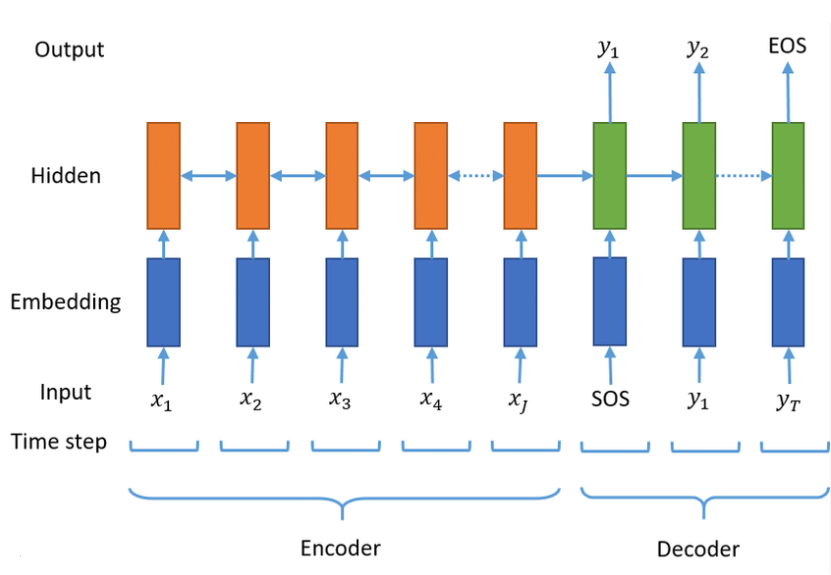
   
  **The basic seq2seq model. SOS and EOS represent the start and end of a sequence, respectively.**

* Output seq generated by the model may be of different lengths, so it’s necessary to use dummy tokens to mark the start of seq(<SOS>) and end of seq(<EOS>),
* Input is preprocessed using padding(<PAD>) to have the same length input sequence




***Language Translation using Seq2Seq Model***

**The module implements the Seq2Seq model for language translation from English to French.**
This module implements Seq2Seq model using Pytorch. You'll learn-
1. How to implement encoder module with GRU layer
2. How to implement decoder module with GRU layer
3. How to implement attention with seq2seq model
4. Preprocess and prepare the data using Pytorch function
5. Train and evaluate the model
6. Visualize the output

In [1]:
#importing all the required libraries
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import os
import re
import random

Downloading and unzipping language conversion data file i.e french to english  




In [2]:
!wget -p http://www.manythings.org/anki/fra-eng.zip data/fra-eng/

--2025-11-09 20:03:43--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8186368 (7.8M) [application/zip]
Saving to: ‘www.manythings.org/anki/fra-eng.zip’

www.manythings.org/ 100%[===================>]   7.81M  16.1MB/s    in 0.5s    

2025-11-09 20:03:43 (16.1 MB/s) - ‘www.manythings.org/anki/fra-eng.zip’ saved [8186368/8186368]

--2025-11-09 20:03:43--  http://data/fra-eng/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
FINISHED --2025-11-09 20:03:43--
Total wall clock time: 0.7s
Downloaded: 1 files, 7.8M in 0.5s (16.1 MB/s)


In [3]:
!unzip www.manythings.org/anki/fra-eng.zip -d www.manythings.org/anki/fra-eng/

Archive:  www.manythings.org/anki/fra-eng.zip
  inflating: www.manythings.org/anki/fra-eng/_about.txt  
  inflating: www.manythings.org/anki/fra-eng/fra.txt  


Downloading and unzipping language conversion data file i.e indonesian to english  


In [4]:
!wget -p http://www.manythings.org/anki/ind-eng.zip data/ind-eng/

--2025-11-09 20:03:47--  http://www.manythings.org/anki/ind-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565874 (553K) [application/zip]
Saving to: ‘www.manythings.org/anki/ind-eng.zip’

www.manythings.org/ 100%[===================>] 552.61K  2.21MB/s    in 0.2s    

2025-11-09 20:03:47 (2.21 MB/s) - ‘www.manythings.org/anki/ind-eng.zip’ saved [565874/565874]

--2025-11-09 20:03:47--  http://data/ind-eng/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
FINISHED --2025-11-09 20:03:47--
Total wall clock time: 0.4s
Downloaded: 1 files, 553K in 0.2s (2.21 MB/s)


In [5]:
!unzip www.manythings.org/anki/ind-eng.zip -d www.manythings.org/anki/ind-eng/

Archive:  www.manythings.org/anki/ind-eng.zip
  inflating: www.manythings.org/anki/ind-eng/_about.txt  
  inflating: www.manythings.org/anki/ind-eng/ind.txt  


In [6]:
#set the input parameters
data_dir = 'www.manythings.org/anki/fra-eng/'#'www.manythings.org/anki/hin-eng/'#
src_lang = 'eng' # source language- english
tgt_lang = 'fra' # target language- french

Vocabulary class defined to store tokens, its position and each token count in sentence.

In [7]:
#tokens to mark start and end of sequence
SOS_token = 0
EOS_token = 1

MAX_LENGTH = 20

#initialize vocabulary Class
class Vocabulary:
   def __init__(self):
       #initialize dictionaries to hold the token-index pairs
       self.token2idx = {} #stores token-index pair
       self.token2cnt = {} # stores count of each token
       self.idx2token = {0: "SOS", 1: "EOS"}# stores index-token pair. Here "SOS" denotes start of sequence token and "EOS" denotes end of sequence token.
       self.num_token = 2  # Count SOS and EOS

#split a sentence into tokens based on white space and add it to the dictionary
   def add_tokens(self, seq):
       for token in seq.split(' '):
           self.create_vocab(token)

#If the token is not in the container, the token will be added to it,
#else, update the token counter
   def create_vocab(self, token):
       if token not in self.token2idx:
           self.token2idx[token] = self.num_token
           self.token2cnt[token] = 1
           self.idx2token[self.num_token] = token
           self.num_token += 1
       else:
           self.token2cnt[token] += 1

In [8]:
#preprocess the data

def normalize_sentence(df, lang):
   sentence = df[lang].str.lower() # converting language data in data frame to lower case and then storing in sentence variable
   if lang != 'hin':  #if lang is not hindi
    sentence = sentence.str.replace('[^A-Za-z\s]+', '') # replacing string in a sentence variable with quotes
    sentence = sentence.str.normalize('NFD')
    sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8') #encoding the string in sentence in UTF-8 format and ignoring errors if any
   print(sentence) #printing sentence variable data
   return sentence # returning sentence

def read_sentence(df, lang1, lang2):
   sentence1 = normalize_sentence(df, lang1)# function normalize_sentence call with data frame, lang1(i.e language that needs to be converted) as parameter
   sentence2 = normalize_sentence(df, lang2)# function normalize_sentence call with data frame, lang2(i.e language in which to convert) as parameter
   return sentence1, sentence2

def read_file(loc, lang1, lang2):
   df = pd.read_csv(loc, delimiter='\t', usecols=[lang1, lang2], names=[lang1, lang2])
   #df = df.reset_index()
   #df.rename(columns = {'index':lang1},inplace = True)
   return df

def process_data(lang1,lang2):
   # function read_file call with text file path, lang1(source lang), lang2(target lang) as parameter
   df = read_file('%s/%s.txt' % (data_dir,lang2), lang1, lang2)
   print("Read %s sentence pairs" % len(df)) # printing total no. of sentence pairs
   sentence1, sentence2 = read_sentence(df, lang1, lang2)# function read_sentence call with df ,lang1, lang2 as parameter

  #initialize source and target
   source = Vocabulary()
   target = Vocabulary()
   pairs = [] #create the pair of source and target [lang1, lang2]
   for i in range(len(df)):  #for all rows in the dataset (each row contains 2 columns for each of language lang1 and lang2)
       if len(sentence1[i].split(' ')) < MAX_LENGTH and len(sentence2[i].split(' ')) < MAX_LENGTH:  #if sentence length(i.e. number of words\tokens is less then MAX_LENGTH, discarding outliers with very long sequences)
           full = [sentence1[i], sentence2[i]] #creating the pair
           source.add_tokens(sentence1[i])  #adding lang1 sentence to the source
           target.add_tokens(sentence2[i]) #adding lang2 entence to the target
           pairs.append(full)   # updating pairs with new data

   return source, target, pairs


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3848941840.py:6: SyntaxWarning: invalid escape sequence '\s'
  sentence = sentence.str.replace('[^A-Za-z\s]+', '') # replacing string in a sentence variable with quotes


In [9]:
#check the process_data function
source, target, pairs = process_data(src_lang, tgt_lang)


Read 239189 sentence pairs
0                                                       go.
1                                                       go.
2                                                       go.
3                                                       go.
4                                                       hi.
                                ...                        
239184    death is something that we're often discourage...
239185    since there are usually multiple websites on a...
239186    if someone who doesn't know your background sa...
239187    it may be impossible to get a completely error...
239188    i went drinking with one of my boyfriend's fri...
Name: eng, Length: 239189, dtype: object
0                                                      va !
1                                                   marche.
2                                                en route !
3                                                   bouge !
4                               

In [10]:
#displaying the pairs(lang1,lang2)
pairs

[['go.', 'va !'],
 ['go.', 'marche.'],
 ['go.', 'en route !'],
 ['go.', 'bouge !'],
 ['hi.', 'salut !'],
 ['hi.', 'salut.'],
 ['run!', 'cours!'],
 ['run!', 'courez!'],
 ['run!', 'prenez vos jambes a vos cous !'],
 ['run!', 'file !'],
 ['run!', 'filez !'],
 ['run!', 'cours !'],
 ['run!', 'fuyez !'],
 ['run!', 'fuyons !'],
 ['run.', 'cours!'],
 ['run.', 'courez!'],
 ['run.', 'prenez vos jambes a vos cous !'],
 ['run.', 'file !'],
 ['run.', 'filez !'],
 ['run.', 'cours !'],
 ['run.', 'fuyez !'],
 ['run.', 'fuyons !'],
 ['who?', 'qui ?'],
 ['wow!', 'ca alors!'],
 ['wow!', 'waouh!'],
 ['wow!', 'wah!'],
 ['duck!', 'a terre!'],
 ['duck!', 'baisse-toi!'],
 ['duck!', 'baissez-vous!'],
 ['fire!', 'au feu !'],
 ['help!', "a l'aide !"],
 ['hide.', 'cache-toi.'],
 ['hide.', 'cachez-vous.'],
 ['jump!', 'saute.'],
 ['jump.', 'saute.'],
 ['stop!', 'ca suffit!'],
 ['stop!', 'stop!'],
 ['stop!', 'arrete-toi !'],
 ['wait!', 'attends !'],
 ['wait!', 'attendez !'],
 ['wait!', 'attendez.'],
 ['wait.', 'atte

In [11]:
# function to get index from token. Token is found out by splitting sentence by '  '(space). It returns set of indexes of corresponding tokens in sentence.
# function requires two parameters lang & sentence. lang parameter to store indexes of corresponding token and sentence parameter to find token.
def get_index_from_token(lang, sentence):
   return [lang.token2idx[token] for token in sentence.split(' ')] #return the index of a particular tokens, max_index is equal to total no. of tokens in the vocabulary

#For Pytorch, we need to covert the vector(vector of all indexes for all tokens in a given sentence into tensor)
def convert_2tensors(lang, sentence):
   indexes = get_index_from_token(lang, sentence) #get the vector of all indexes for all tokens in a given sentence
   indexes.append(EOS_token) #update the indexes vecotr with new sentence
   return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) #convert into pytorch tensor, dtyoe =lang because all indexes are integers

#For creating training data, we need to create pairs of tensors for both source and target sentences
def create_src_tgt_tensor_pairs(input_lang, output_lang, pair):
   input_tensor = convert_2tensors(input_lang, pair[0])  #get tensor for source sentence
   target_tensor = convert_2tensors(output_lang, pair[1]) #get tensor for target sentence
   return (input_tensor, target_tensor) # return the pair

In [12]:
#This is the first part of our seq2seq model called encoder
#We need to pass the input, hidden and embedding dimension
#input_dim - max_length of the sequence
#hidden_dim - hyperparameterm, we can eperiment with different values
#embedding_dim - again an hyperparameter, which we can experiment with different values, embedding dimension (token representation) for each token
#num_layers - another hyperparameter, more layers are better for complex problem like language translation
class seq_encoder(nn.Module):
   def __init__(self, input_dim, hidden_dim, embbed_dim, num_layers):
       super(seq_encoder, self).__init__()

       #set the encoder input dimesion , embbed dimesion, hidden dimesion, and number of layers
       self.input_dim = input_dim
       self.embbed_dim = embbed_dim
       self.hidden_dim = hidden_dim
       self.num_layers = num_layers

       #initialize the embedding layer with input and embbed dimention
       self.embedding = nn.Embedding(input_dim, self.embbed_dim)
       #intialize the LSTM to take the input dimetion of embbed, and output dimention of hidden and
       #set the number of LSTM layers
       self.lstm = nn.LSTM(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)

   #forward pass in the neural network
   def forward(self, src):

       embedded = self.embedding(src).view(1,1,-1) #get the embedding
       outputs, hidden = self.lstm(embedded) #get the output and the hidden state from LSTM
       return outputs, hidden

In [13]:
#This is the 2nd component of the seq2seq modle called decoder
#Typically, structure of decoder is sam eas structure of decoder, exceot the size of the ouput dim, which is nothing but no. of unique tokens in the target language
class seq_decoder(nn.Module):
   def __init__(self, output_dim, hidden_dim, embbed_dim, num_layers):
       super(seq_decoder, self).__init__()

#set the encoder output dimension, embed dimension, hidden dimension, and number of layers
       self.embbed_dim = embbed_dim
       self.hidden_dim = hidden_dim
       self.output_dim = output_dim
       self.num_layers = num_layers

# initialize every layer with the appropriate dimension. For the decoder layer, it will consist of an embedding, GRU, a Linear layer and a Log softmax activation function.
       self.embedding = nn.Embedding(output_dim, self.embbed_dim)
       self.lstm = nn.LSTM(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)
       self.out = nn.Linear(self.hidden_dim, output_dim)
       self.softmax = nn.LogSoftmax(dim=1)

#define the forward pass through the decoder
   def forward(self, input, hidden):

# reshape the input to (1, batch_size)
       input = input.view(1, -1)
       embedded = F.relu(self.embedding(input))
       output, hidden = self.lstm(embedded, hidden)
       prediction = self.softmax(self.out(output[0]))

       return prediction, hidden

In [14]:
#The module combine the encoder and decoder part and process the sequence over the full network
class seq2seq(nn.Module):
   def __init__(self, encoder, decoder, device, MAX_LENGTH=MAX_LENGTH):
       super().__init__()

#initialize the encoder and decoder
       self.encoder = encoder
       self.decoder = decoder
       self.device = device

   def forward(self, source, target, teacher_forcing_ratio=0.5):

       input_length = source.size(0) #get the input length (number of words in sentence)
       batch_size = target.shape[1]
       target_length = target.shape[0]
       vocab_size = self.decoder.output_dim

#initialize a variable to hold the predicted outputs
       outputs = torch.zeros(target_length, batch_size, vocab_size).to(self.device)

#encode every word in a sentence
       for i in range(input_length):
           encoder_output, encoder_hidden = self.encoder(source[i])

#use the encoder’s hidden layer as the decoder hidden
       decoder_hidden = encoder_hidden

#add a token before the first predicted word
       decoder_input = torch.tensor([SOS_token], device=device)  # SOS

#topk is used to get the top K value over a list
#predict the output word from the current target word. If we enable the teaching force,  then the #next decoder input is the next word, else, use the decoder output highest value.

       for t in range(target_length):
           decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
           outputs[t] = decoder_output
           teacher_force = random.random() < teacher_forcing_ratio
           topv, topi = decoder_output.topk(1)
           input = (target[t] if teacher_force else topi)
           if(teacher_force == False and input.item() == EOS_token):
               break

       return outputs

In [15]:
#set the teacher forcing ratio
teacher_forcing_ratio = 0.5

#define the seq2seq model and the training pipeline
#Pytorch training pipelines, there are 5 steps irrespective of the model type
#1. initialize the zero grad
#2. Get the output from the model for training sequence
#3. compute the loss
#4. backpropagate the loss
#5. optimize the weight


def create_seq2seq_model(model, input_tensor, target_tensor, model_optimizer, criterion):
   #initialize the gradient
   #1
   model_optimizer.zero_grad()

   #get the input tensor size
   input_length = input_tensor.size(0)
   loss = 0
   epoch_loss = 0
   # print(input_tensor.shape)
   #modle output from the decoder
   #2
   output = model(input_tensor, target_tensor)

   num_iter = output.size(0)
   #print(num_iter)
#3
#calculate the loss from a predicted sentence with the expected result
   for ot in range(num_iter):
       loss += criterion(output[ot], target_tensor[ot])

   #4.
   loss.backward()
   #5.
   model_optimizer.step()
   epoch_loss = loss.item() / num_iter

   return epoch_loss

#this module will train the model for given number of iterations
def train_model(model, source, target, pairs, num_iteration=20000):
   model.train()

   #defining the optimizer
   #we are using SGD here, you can experiment with other optimizer like rmsprop, adam etc.
   optimizer = optim.SGD(model.parameters(), lr=0.01)

   #define the loss function
   criterion = nn.NLLLoss()
   total_loss_iterations = 0

   #get the training data
   training_pairs = [create_src_tgt_tensor_pairs(source, target, random.choice(pairs))
                     for i in range(num_iteration)]

   #for each iteration
   #1. Get training pair
   #2. Compute the loss
   #3. Optimize modle weights
   #4. Reiterate
   for iter in range(1, num_iteration+1):
       training_pair = training_pairs[iter - 1]
       input_tensor = training_pair[0]
       target_tensor = training_pair[1]

       #get the loss for the current iteration, training loss should minimized over time, there will some fluctuation
       loss = create_seq2seq_model(model, input_tensor, target_tensor, optimizer, criterion)

       #get the total loss
       total_loss_iterations += loss

       #this step required to compute the average loss per 100 iterations
       if iter % 100 == 0:
           avarage_loss= total_loss_iterations / 100
           total_loss_iterations = 0
           print('%d %.4f' % (iter, avarage_loss))

   #save the model
   torch.save(model.state_dict(), 'mytraining.pt')
   return model

In [16]:
#this module evaluate the seq2seq model on the test data
def evaluate(model, input_lang, output_lang, sentences, max_length=MAX_LENGTH):
   #on test data, we are not required to compute the gradient, so we need to call torch.no_grad()
   with torch.no_grad():
       # get the source and target tensor same as training step
       input_tensor = convert_2tensors(input_lang, sentences[0])
       output_tensor = convert_2tensors(output_lang, sentences[1])

       #variable to store the model output
       decoded_words = []

       #calling the trained model on the given sequence and modle will generate the output tensors which is nothing but the probability of a particular word/token
       output = model(input_tensor, output_tensor)
       # print(output_tensor)

       #loop over the output, until we see the <EOS> token, this is required because modle can generate output of variable length
       for ot in range(output.size(0)):
           #get the token with maximum probability(greedy approach, we can also get top k tokens(allow randomization)
           topv, topi = output[ot].topk(1)
           # print(topi)

           #check for <EOS> token
           if topi[0].item() == EOS_token:
               decoded_words.append('<EOS>')
               break
           else:
               decoded_words.append(output_lang.idx2token[topi[0].item()]) #get the token from the index and append to the output array
   return decoded_words

#evaluate the model on the random subset
def evaluateRandomly(model, source, target, pairs, n=10):
  #select n random samples
   for i in range(n):
       pair = random.choice(pairs) #get the random pair
       print("source {}".format(pair[0]))
       print("target {}".format(pair[1]))
       output_words = evaluate(model, source, target, pair) #evaluate the model
       output_sentence = ' '.join(output_words)
       print("predicted {}".format(output_sentence)) #print the generated sentences

In [17]:
#device agnostic code, if gpu available use "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#get the training data- source, taget and pair
source, target, pairs = process_data(src_lang, tgt_lang)

#randomize and shuffle the training data, this is required so that model doesn't depends on a particular order of training data
randomize = random.choice(pairs)
print('random sentence {}'.format(randomize))

#print number of words, get all tokens from source and target
input_size = source.num_token
output_size = target.num_token
print('Input : {} Output : {}'.format(input_size, output_size))

#initialize model hyerparameters, you csn experiment with different values
embed_size = 256
hidden_size = 512
num_layers = 1
num_iteration = 10

#create encoder-decoder model
encoder = seq_encoder(input_size, hidden_size, embed_size, num_layers)
decoder = seq_decoder(output_size, hidden_size, embed_size, num_layers)

#initialie the model
model = seq2seq(encoder, decoder, device).to(device)

#print model
print(encoder)
print(decoder)

#model training
model = train_model(model, source, target, pairs, num_iteration)


Read 239189 sentence pairs
0                                                       go.
1                                                       go.
2                                                       go.
3                                                       go.
4                                                       hi.
                                ...                        
239184    death is something that we're often discourage...
239185    since there are usually multiple websites on a...
239186    if someone who doesn't know your background sa...
239187    it may be impossible to get a completely error...
239188    i went drinking with one of my boyfriend's fri...
Name: eng, Length: 239189, dtype: object
0                                                      va !
1                                                   marche.
2                                                en route !
3                                                   bouge !
4                               

In [18]:
#model evaluation on the test data
evaluateRandomly(model, source, target, pairs)

source she had a good time talking with him about his trip.
target elle a passe un agreable moment a s'entretenir avec lui au sujet de son voyage.
predicted ne <EOS>
source tom likes playing volleyball.
target tom aime jouer au volley.
predicted ne <EOS>
source raise your hand before you answer.
target leve la main avant de repondre.
predicted ne <EOS>
source it is evident that he has made a mistake.
target il est evident qu'il a commis une erreur.
predicted ne <EOS>
source we sat face to face with executives.
target nous etions assis face aux cadres.
predicted ne <EOS>
source i wish that we could spend more time together.
target j'aimerais qu'on puisse passer plus de temps ensemble.
predicted ne <EOS>
source tom hasn't read the morning paper yet.
target tom n'a pas encore lu le journal du matin.
predicted ne <EOS>
source i know that feeling.
target je connais ce sentiment.
predicted ne <EOS>
source who is it that you want to talk to?
target a qui veux-tu parler ?
predicted ne <EOS>
so